In [1300]:
import numpy as np 
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()
from tqdm import tqdm 

In [1301]:
def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

In [1302]:
param_name = "Theta_5"

with open(f'/home/chri6578/Documents/CES/params/{param_name}.pickle', 'rb') as file:
    Theta = pickle.load(file)
    
n = Theta['n']
Lambda = Theta['Lambda']
Eta = Theta['Eta']
Alpha = Theta['Alpha']
Beta = Theta['Beta']
Gamma = Theta['Gamma']
T = 1e6

In [1303]:
# step 2
PHI = {}

for i in range(n):
    PHI[i] = []
    t = 0
    t_prev = 0
    while t_prev < T:
        t = np.random.exponential(Lambda[i])[0]
        PHI[i].append(t + t_prev)
        t_prev = t + t_prev

In [1286]:
# step 3
tuple_list = [(i, t) for i in range(n) for t in PHI[i]]
T_list = sorted(tuple_list, key=lambda x: x[1])

In [1287]:
# steps 4-11

E_all = {}
for i in range(n):
    E_all[i] = []
t_last = np.zeros((n,))

for (e,t) in T_list:
    # update x_i^t
    s = np.sum( Gamma[e]*np.power(t- t_last, Alpha[e]-1)*np.exp(-(t-t_last)*Beta[e])*(t_last != 0) ) + Eta[e]
    p = sigmoid(s)
    # print(s, p)
    trial = np.random.binomial(1,p)
    if trial:
        E_all[e].append(t)
        t_last[e] = t

/tmp/ipykernel_4102952/343821928.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-x))


In [1288]:
# save PHI, and E_all

# load Theta, PHI, and E_all

In [1289]:
# Estimating Probability of Causation 

tau_bar = 5e2

Pn = np.zeros((n,n))
Ps = np.zeros((n,n))
Pns = np.zeros((n,n))

for i in tqdm(range(n)):
    Pa_i = [k for k in  range(n) if Alpha[i][k] > 0 ]
    print(Pa_i)
    for j in range(n):
        gPn = [] 
        gPs = [] 
        n_yz_ = 0
        n_y_z = 0
        for t in PHI[i]:
            # search for j in (t -tau_bar, t)
            Lij = [t_ for t_ in E_all[j] if t - tau_bar < t_ < t]
            if len(Lij) > 0:
                if t in E_all[i]:
                    # (y_i, z_j)
                    t_last = np.zeros((n,))
                    for k in Pa_i:
                        Lik = [t_ for t_ in E_all[k] if t - tau_bar < t_ < t]
                        if len(Lik)>0:
                            t_last[k] = np.max(Lik)
                            
                    t_last[j] = 0 # imposing z_j' 
                    
                    #calculate probability of necessity                    
                    gPn.append(
                        1 -sigmoid( np.sum( Gamma[i]*np.power(t- t_last, Alpha[i]-1)*np.exp(-(t-t_last)*Beta[i])*(t_last != 0) ) 
                                + Eta[i] )[0]
                    )
                    
                
                else:
                    # (y_i', z_j)
                    n_y_z += 1
            
            else:
                if t not in E_all[i]:
                    # (y_i', z_j')
                    t_last = np.zeros((n,))
                    for k in Pa_i:
                        Lik = [t_ for t_ in E_all[k] if t - tau_bar < t_ < t]
                        if len(Lik)>0:
                            t_last[k] = np.max(Lik)
                            
                    t_last[j] = np.random.uniform(t- tau_bar, t) # imposing z_j 
                    
                    #calculate probability of necessity                    
                    gPs.append(
                        sigmoid( np.sum( Gamma[i]*np.power(t- t_last, Alpha[i]-1)*np.exp(-(t-t_last)*Beta[i])*(t_last != 0) ) 
                                + Eta[i] )[0]
                    )
                
                else:
                    # (y_i, z_j')
                    n_yz_ += 1
                    
        # Calculate probabilities here
        
        gPn_mean = np.nanmean(gPn)
        gPs_mean = np.nanmean(gPs)
        
        
        Pn[i][j] = 0 if np.isnan(gPn_mean) else gPn_mean  
        Ps[i][j] = 0 if np.isnan(gPs_mean) else gPs_mean
        
        total = len(gPn) + len(gPs) + n_y_z + n_yz_
        Pns[i][j] = ( len(gPn)*Pn[i][j] + len(gPs)*Ps[i][j] )/ total

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_4102952/3798833921.py:66: RuntimeWarning: Mean of empty slice
  gPs_mean = np.nanmean(gPs)


[0, 4]


  5%|▌         | 1/20 [00:53<16:48, 53.05s/it]/tmp/ipykernel_4102952/343821928.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-x))


[1, 3, 8, 10]


/tmp/ipykernel_4102952/3798833921.py:65: RuntimeWarning: Mean of empty slice
  gPn_mean = np.nanmean(gPn)
 10%|█         | 2/20 [01:18<11:06, 37.02s/it]

[2, 19]


 15%|█▌        | 3/20 [02:32<15:09, 53.52s/it]

[2, 3, 6, 7, 17]


 20%|██        | 4/20 [04:19<19:57, 74.86s/it]

[4, 7, 12]


 25%|██▌       | 5/20 [09:01<37:23, 149.54s/it]

[5, 13, 14, 18]


 30%|███       | 6/20 [09:05<23:18, 99.90s/it] 

[6, 7]


 35%|███▌      | 7/20 [09:22<15:49, 73.07s/it]

[4, 7]


 40%|████      | 8/20 [14:35<29:50, 149.22s/it]

[8, 18, 19]


 45%|████▌     | 9/20 [15:05<20:31, 112.00s/it]

[6, 9, 10]


 50%|█████     | 10/20 [16:21<16:48, 100.86s/it]

[0, 10, 17]


 55%|█████▌    | 11/20 [16:42<11:27, 76.40s/it] 

[3, 4, 5, 11, 19]


 60%|██████    | 12/20 [17:35<09:16, 69.51s/it]

[12, 16]


 65%|██████▌   | 13/20 [17:41<05:51, 50.20s/it]

[1, 11, 13, 14]


 70%|███████   | 14/20 [18:24<04:47, 47.98s/it]

[0, 10, 14, 16]


 75%|███████▌  | 15/20 [20:22<05:44, 68.98s/it]

[0, 9, 15]


 80%|████████  | 16/20 [20:56<03:54, 58.55s/it]

[1, 5, 7, 16]


 85%|████████▌ | 17/20 [21:36<02:38, 52.82s/it]

[6, 17]


 90%|█████████ | 18/20 [22:39<01:52, 56.15s/it]

[0, 17, 18]


 95%|█████████▌| 19/20 [24:09<01:06, 66.17s/it]

[18, 19]


100%|██████████| 20/20 [24:12<00:00, 72.64s/it]


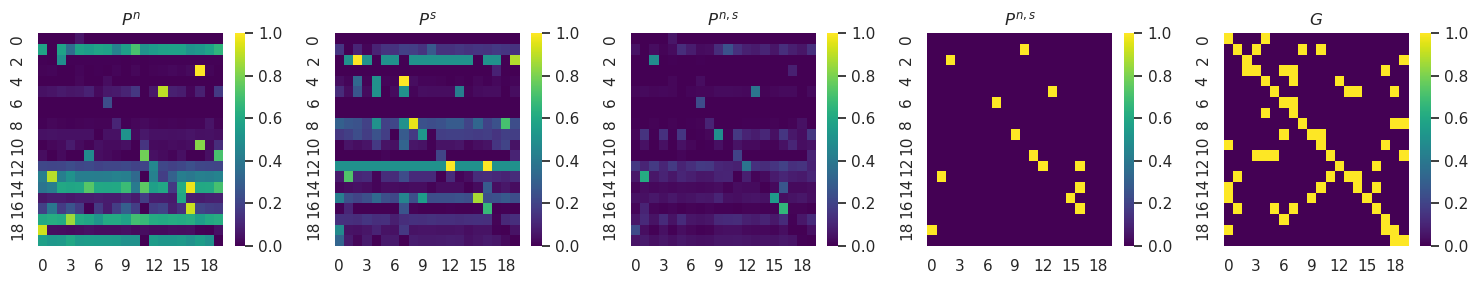

In [1299]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Plot each heatmap
sns.heatmap(Pn, ax=axes[0], cmap="viridis", vmin=0, vmax=1)
axes[0].set_title("$ P^n $")

sns.heatmap(Ps, ax=axes[1], cmap="viridis", vmin=0, vmax=1)
axes[1].set_title("$ P^s $")

sns.heatmap(Pns, ax=axes[2], cmap="viridis", vmin=0, vmax=1)
axes[2].set_title("$ P^{n,s} $")

sns.heatmap(Pns > 0.18, ax=axes[3], cmap="viridis")
axes[3].set_title("$ P^{n,s} $")

sns.heatmap(Alpha>0, ax=axes[4], cmap="viridis", vmin=0, vmax=1)
axes[4].set_title("$ G $")

# Adjust layout
plt.tight_layout()
plt.show()

In [1291]:
G = np.double(Alpha > 0)

In [1292]:
np.linalg.norm(G - Pn)/n, np.linalg.norm(G - Ps)/n, np.linalg.norm(G - Pns )/n

(0.4109891266168977, 0.3779287737666742, 0.3654981033971412)

/tmp/ipykernel_4102952/343821928.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-x))


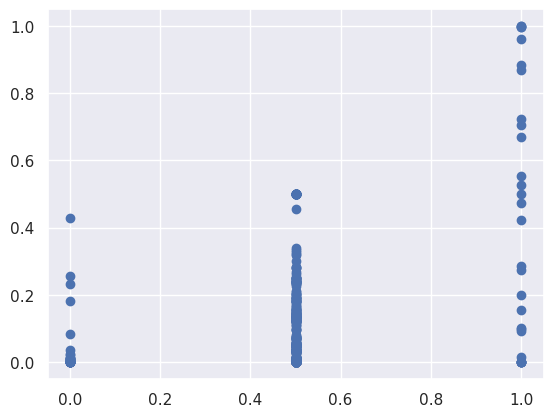

In [1293]:
plt.scatter(sigmoid(Gamma), Ps)
# plt.scatter(Gamma, Ps)
# plt.scatter(Gamma, Pn)